In [1]:
from dataclasses import dataclass
import pandas as pd
%matplotlib inline
import random
import statsmodels.api as sm

In [2]:
@dataclass
class ModelInputs:
    starting_salary: int = 60000
    promos_every_n_years: int = 5
    cost_of_living_raise: float = 0.02
    promo_raise: float = 0.15
    savings_rate: float = 0.25
    interest_rate: float = 0.05
    desired_cash: int = 1500000
        
data = ModelInputs()
data

ModelInputs(starting_salary=60000, promos_every_n_years=5, cost_of_living_raise=0.02, promo_raise=0.15, savings_rate=0.25, interest_rate=0.05, desired_cash=1500000)

In [3]:
@dataclass
class SimluationInputs:
    n_iterations: int = 10000
    starting_salary_std: int = 10000
    promos_every_n_years_std: int = 1.5
    cost_of_living_raise_std: float = 0.005
    promo_raise_std: float = 0.05
    savings_rate_std: float = 0.07
    interest_rate_std: float = 0.01
        
sim_data = SimluationInputs()

In [33]:
sim_data

SimluationInputs(n_iterations=10000, starting_salary_std=10000, promos_every_n_years_std=1.5, cost_of_living_raise_std=0.005, promo_raise_std=0.05, savings_rate_std=0.07, interest_rate_std=0.01)

In [5]:
mean=2
std=1
def random_normal_positive(mean,std):
    drawn_value=-1
    while drawn_value<0:
        drawn_value=random.normalvariate(mean,std)
    return drawn_value

In [6]:
random_normal_positive(1,10)

2.2139129330916294

In [7]:
def years_to_retirement_simulation_inputs(data,sim_data):
    starting_salary = random_normal_positive(data.starting_salary, sim_data.starting_salary_std)
    promos_every_n_years = random_normal_positive(data.promos_every_n_years, sim_data.promos_every_n_years_std)
    cost_of_living_raise = random_normal_positive(data.cost_of_living_raise, sim_data.cost_of_living_raise_std)
    promo_raise = random_normal_positive(data.promo_raise, sim_data.promo_raise_std)
    savings_rate = random_normal_positive(data.savings_rate, sim_data.savings_rate_std)
    interest_rate = random_normal_positive(data.interest_rate, sim_data.interest_rate_std)
    return(
        starting_salary,
        promos_every_n_years,
        cost_of_living_raise,
        promo_raise,
        savings_rate,
        interest_rate
    )

In [8]:
years_to_retirement_simulation_inputs(data,sim_data)

(54368.513373678215,
 3.9761803961351423,
 0.020714195652370815,
 0.183986687360858,
 0.2927756026691778,
 0.04997000923577771)

In [9]:
def wealth_at_year(data: ModelInputs, year, prior_wealth):
    """
    Calculate the accumulated wealth for a given year, based on previous wealth, the investment rate,
    and cash saved during the year.
    """
    cash_saved = cash_saved_during_year(data, year)
    wealth = prior_wealth * (1 + data.interest_rate) + cash_saved
    return wealth

def years_to_retirement(data: ModelInputs, print_output=True):
    
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    
    year = 0  # will become 1 on first loop
    
    if print_output:
        print('Wealths over time:') # \n makes a blank line in the output.
    while wealth < data.desired_cash:
        year = year + 1
        wealth = wealth_at_year(data, year, prior_wealth)
        if print_output:
            print(f'The wealth at year {year} is ${wealth:,.0f}.')

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
    # Now we have exited the while loop, so wealth must be >= desired_cash. Whatever last year was set
    # is the years to retirement.
    if print_output:
        print(f'\nRetirement:\nIt will take {year} years to retire.')  # \n makes a blank line in the output.
    return year

def cash_saved_during_year(data: ModelInputs, year):
    """
    Calculated the cash saved within a given year, by first calculating the salary at that year then applying the 
    savings rate.
    """
    salary = salary_at_year(data, year)
    cash_saved = salary * data.savings_rate
    return cash_saved

def salary_at_year(data: ModelInputs, year):
    """
    Gets the salary at a given year from the start of the model based on cost of living raises and regular promotions.
    """
    # Every n years we have a promotion, so dividing the years and taking out the decimals gets the number of promotions
    num_promos = int(year / data.promos_every_n_years)
    
    # This is the formula above implemented in Python
    salary_t = data.starting_salary * (1 + data.cost_of_living_raise) ** year * (1 + data.promo_raise) ** num_promos
    return salary_t


In [10]:
def years_to_retirement(data: ModelInputs, print_output=True):
    
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    
    year = 0  # will become 1 on first loop
    
    if print_output:
        print('Wealths over time:') # \n makes a blank line in the output.
    while wealth < data.desired_cash:
        year = year + 1
        wealth = wealth_at_year(data, year, prior_wealth)
        if print_output:
            print(f'The wealth at year {year} is ${wealth:,.0f}.')

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
    # Now we have exited the while loop, so wealth must be >= desired_cash. Whatever last year was set
    # is the years to retirement.
    if print_output:
        print(f'\nRetirement:\nIt will take {year} years to retire.')  # \n makes a blank line in the output.
    return year

In [17]:
def years_to_retirement_single_simulations(data,sim_data):
    (starting_salary,
     promos_every_n_years,
     cost_of_living_raise,
     promo_raise,savings_rate,
     interest_rate)=years_to_retirement_simulation_inputs(data,sim_data)

    new_data=ModelInputs(
        starting_salary,
        promos_every_n_years,
        cost_of_living_raise,
        promo_raise,
        savings_rate,
        interest_rate
    )
    ytr=years_to_retirement(new_data,print_output=False)
    
    return(
        starting_salary,
        promos_every_n_years,
        cost_of_living_raise,
        promo_raise,
        savings_rate,
        interest_rate,
        ytr
    )

In [19]:
all_results=[years_to_retirement_single_simulations(data,sim_data) for i in range(sim_data.n_iterations)]
all_results

[(58773.090932659485,
  6.573801254878989,
  0.020772384941411867,
  0.20946924483322882,
  0.21235153860261513,
  0.05136233099121096,
  30),
 (56696.5654684282,
  7.034437760917623,
  0.021803134196958413,
  0.13114634072671572,
  0.3248235563452124,
  0.05912830799729012,
  26),
 (51765.104643289815,
  3.8066572315683844,
  0.015624141043063196,
  0.1488926325979512,
  0.23848360721708772,
  0.04923177495808743,
  30),
 (52899.49790971368,
  5.053785640305531,
  0.020818466288704405,
  0.08715813152996009,
  0.26044976464238967,
  0.04531288342670725,
  32),
 (65030.91864864619,
  4.148092656139347,
  0.02108231177373048,
  0.15400073734121697,
  0.16154210652742135,
  0.0476830065949772,
  32),
 (63980.4703650982,
  5.925470382816142,
  0.01279437574562138,
  0.1424937226679806,
  0.23329560720695605,
  0.05177490378323496,
  30),
 (65049.56696928855,
  6.24383070643278,
  0.017681573928512835,
  0.13558047301054343,
  0.3132400146765019,
  0.06129373734837468,
  25),
 (63388.05451

In [20]:
df=pd.DataFrame(all_results,
                columns=['Starting Salary',
                         'Promos Every n Years',
                         'Cost of Living Raise',
                         'Promotion Raise',
                         'Savings Rate',
                         'Interest rate',
                         'Years to retir'])
df

,Starting Salary,Promos Every n Years,Cost of Living Raise,Promotion Raise,Savings Rate,Interest rate,Years to retir
0,58773.090933,6.573801,0.020772,0.209469,0.212352,0.051362,30
1,56696.565468,7.034438,0.021803,0.131146,0.324824,0.059128,26
2,51765.104643,3.806657,0.015624,0.148893,0.238484,0.049232,30
3,52899.497910,5.053786,0.020818,0.087158,0.260450,0.045313,32
4,65030.918649,4.148093,0.021082,0.154001,0.161542,0.047683,32
...,...,...,...,...,...,...,...
9995,49445.359214,6.523691,0.022023,0.116067,0.140752,0.031713,46
9996,45214.517029,3.676332,0.023412,0.146456,0.202563,0.053595,31
9997,51966.749683,2.235782,0.026562,0.232425,0.370398,0.055289,18
9998,61329.804065,5.514745,0.014402,0.099690,0.194357,0.029517,40


In [51]:
def years_to_retirement_mc(data,sim_data):
    all_results=[years_to_retirement_single_simulations(data,sim_data) for i in range(sim_data.n_iterations)]
    df=pd.DataFrame(
        all_results,
        columns=['Starting Salary',
                 'Promos Every n Years',
                 'Cost of Living Raise',
                 'Promotion Raise',
                 'Savings Rate',
                 'Interest rate',
                 'Years to Retirement']
    )
    return df
df=years_to_retirement_mc(data,SimluationInputs(n_iterations=1000))
df

,Starting Salary,Promos Every n Years,Cost of Living Raise,Promotion Raise,Savings Rate,Interest rate,Years to Retirement
0,65337.636803,4.855716,0.012151,0.182374,0.433558,0.057347,21
1,67435.987569,4.697497,0.022873,0.168199,0.294596,0.043439,25
2,58564.131262,5.440298,0.016032,0.175150,0.261141,0.041165,30
3,54736.536902,6.134153,0.020737,0.194974,0.333103,0.049746,26
4,50457.950920,6.032445,0.017116,0.113272,0.346869,0.058948,27
...,...,...,...,...,...,...,...
995,49615.897529,5.933965,0.023803,0.035125,0.212986,0.064377,33
996,65404.655876,4.725248,0.028955,0.119984,0.107971,0.067411,33
997,64040.984162,5.879707,0.018113,0.170671,0.319499,0.052791,25
998,34448.749317,5.360728,0.011518,0.153602,0.276999,0.037300,40


In [52]:
def style_df(df):
    return df.style.format({
    'Starting Salary':'${:,.0f}',
    'Promos Every N Years':'{:.1f}',
    'Cost of Living Raise':'{:.2%}',
    'Promotion Raise':'{:.2%}',
    'Savings Rate':'{:.2%}',
    'Interest Rate':'{:.2%}',
    'years To Retirement':'{:.0f}'
    }).background_gradient(cmap='RdYlGn_r',subset=['Years to Retirement'])

In [53]:
style_df(df.head())

,Starting Salary,Promos Every n Years,Cost of Living Raise,Promotion Raise,Savings Rate,Interest rate,Years to Retirement
0,"$65,338",4.855716,1.22%,18.24%,43.36%,0.057347,21
1,"$67,436",4.697497,2.29%,16.82%,29.46%,0.043439,25
2,"$58,564",5.440298,1.60%,17.51%,26.11%,0.041165,30
3,"$54,737",6.134153,2.07%,19.50%,33.31%,0.049746,26
4,"$50,458",6.032445,1.71%,11.33%,34.69%,0.058948,27


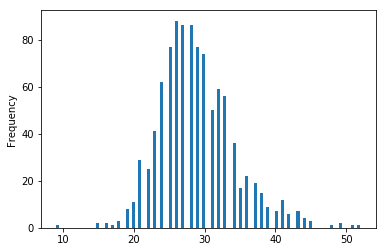

In [56]:
df['Years to Retirement'].plot.hist(bins=100)

In [58]:
df.quantile([i/20 for i in range(1,20)])

,Starting Salary,Promos Every n Years,Cost of Living Raise,Promotion Raise,Savings Rate,Interest rate,Years to Retirement
0.05,44088.513030,2.538249,0.011427,0.068396,0.132599,0.032988,21.00
0.10,47464.424251,3.105077,0.013402,0.086400,0.158032,0.037149,23.00
0.15,49442.856594,3.483713,0.014508,0.097698,0.176280,0.039314,24.00
0.20,51824.484011,3.744908,0.015672,0.108023,0.189655,0.041145,25.00
0.25,53554.617204,3.969567,0.016490,0.115773,0.202684,0.042456,25.00
0.30,54980.032697,4.198768,0.017247,0.122376,0.212576,0.044206,26.00
0.35,56208.110006,4.400462,0.018119,0.128916,0.222989,0.045553,26.65
0.40,57395.493679,4.605779,0.018800,0.136603,0.232677,0.047031,27.00
0.45,58718.943836,4.813357,0.019328,0.142934,0.243005,0.048272,28.00
0.50,59790.566455,4.970477,0.020106,0.148189,0.253410,0.049793,28.00


In [59]:
style_df(df.quantile([i/20 for i in range(1,20)]))

,Starting Salary,Promos Every n Years,Cost of Living Raise,Promotion Raise,Savings Rate,Interest rate,Years to Retirement
0.05,"$44,089",2.538249,1.14%,6.84%,13.26%,0.032988,21.000000
0.1,"$47,464",3.105077,1.34%,8.64%,15.80%,0.037149,23.000000
0.15,"$49,443",3.483713,1.45%,9.77%,17.63%,0.039314,24.000000
0.2,"$51,824",3.744908,1.57%,10.80%,18.97%,0.041145,25.000000
0.25,"$53,555",3.969567,1.65%,11.58%,20.27%,0.042456,25.000000
0.3,"$54,980",4.198768,1.72%,12.24%,21.26%,0.044206,26.000000
0.35,"$56,208",4.400462,1.81%,12.89%,22.30%,0.045553,26.650000
0.4,"$57,395",4.605779,1.88%,13.66%,23.27%,0.047031,27.000000
0.45,"$58,719",4.813357,1.93%,14.29%,24.30%,0.048272,28.000000
0.5,"$59,791",4.970477,2.01%,14.82%,25.34%,0.049793,28.000000


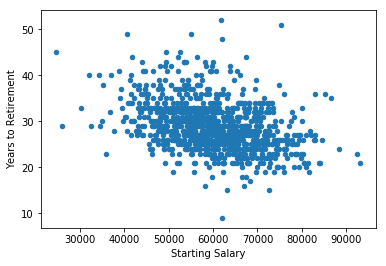

In [60]:
df.plot.scatter(y='Years to Retirement',x='Starting Salary')

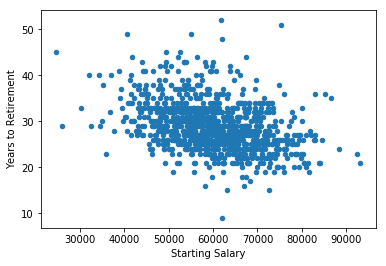

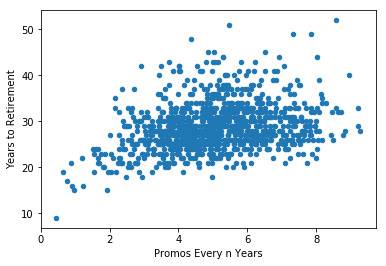

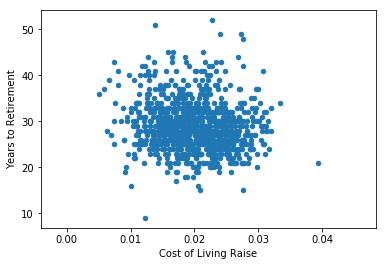

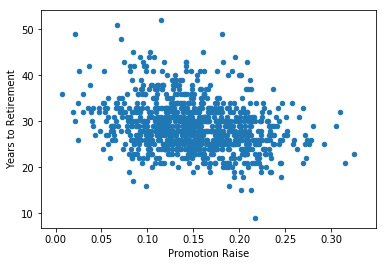

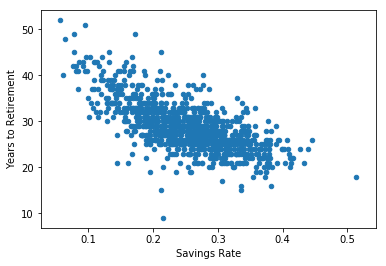

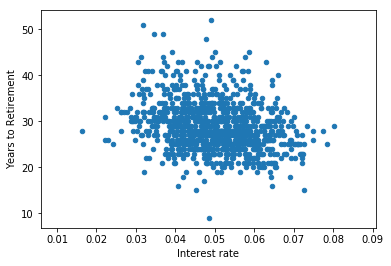

In [62]:
input_cols=[
    'Starting Salary',
    'Promos Every n Years',
    'Cost of Living Raise',
    'Promotion Raise',
    'Savings Rate',
    'Interest rate']

    
for col in input_cols:
    df.plot.scatter(y='Years to Retirement',x=col)

In [66]:
output_col='Years to Retirement'
x=sm.add_constant(df[input_cols])
y=df[output_col]

mod=sm.OLS(y,x)
result=mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Years to Retirement   R-squared:                       0.897
Model:                             OLS   Adj. R-squared:                  0.896
Method:                  Least Squares   F-statistic:                     1435.
Date:                 Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                         20:57:08   Log-Likelihood:                -1955.9
No. Observations:                 1000   AIC:                             3926.
Df Residuals:                      993   BIC:                             3960.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   63.2311      0.566    111.710      0.000      62.120      64.342
Starting Salary         -0.0002   5.49e-06    -37.699      0.000      -0.000      -0.000
Promos Every n Years     1.2420      0.036     34.782      0.000       1.172       1.312
Cost of Living Raise  -152.9861     10.682    -14.322      0.000    -173.948    -132.024
Promotion Raise        -28.6591      1.082    -26.480      0.000     -30.783     -26.535
Savings Rate           -52.2883      0.765    -68.313      0.000     -53.790     -50.786
Interest rate         -153.8924      5.340    -28.820      0.000    -164.371    -143.414
==============================================================================
Omnibus:                      238.375   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6194.635
Skew:                          -0.450   Prob(JB):                         0.00
Kurtosis:                      15.160   Cond. No.                     1.20e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
sim_data

SimluationInputs(n_iterations=10000, starting_salary_std=10000, promos_every_n_years_std=1.5, cost_of_living_raise_std=0.005, promo_raise_std=0.05, savings_rate_std=0.07, interest_rate_std=0.01)

In [69]:
result.params

const                    63.231051
Starting Salary          -0.000207
Promos Every n Years      1.241998
Cost of Living Raise   -152.986112
Promotion Raise         -28.659101
Savings Rate            -52.288335
Interest rate          -153.892357
dtype: float64

In [70]:
df.std()

Starting Salary         9938.242477
Promos Every n Years       1.528363
Cost of Living Raise       0.005091
Promotion Raise            0.050292
Savings Rate               0.071161
Interest rate              0.010181
Years to Retirement        5.322922
dtype: float64

In [72]:
result.params*df.std()#standerdize coefficient

Cost of Living Raise   -0.778853
Interest rate          -1.566741
Promos Every n Years    1.898224
Promotion Raise        -1.441317
Savings Rate           -3.720897
Starting Salary        -2.056963
Years to Retirement          NaN
const                        NaN
dtype: float64